In [1]:
import requests
from io import BytesIO
from zipfile import ZipFile
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.metrics import classification_report

In [2]:
#download dataset

dataset_link = 'https://universe.roboflow.com/ds/34oBZCp0Y9?key=M2AxU6iuig'
response = requests.get(dataset_link)
zip_file = ZipFile(BytesIO(response.content))

# Extract the dataset to a specific directory
extracted_folder = '/dataset'
zip_file.extractall(extracted_folder)

In [3]:
transform_train = transforms.Compose(
    [
        #all the images are currently 224 pixels but we can rezie later according to model accuracy to see if it makes any difference
        transforms.Resize((224,224)),
        #using such random flips, helps to increase variability in your training data,
        # which can prevent overfitting and improve the model's ability to generalize to unseen data (can add explanation in report)
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

transform_test = transforms.Compose(
    [
         #all the images are currently 224 pixels but we can rezie later according to model accuracy to see if it makes any difference
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

In [4]:
# Define object of the Train, Validation, and Test dataset.
train_dataset = torchvision.datasets.ImageFolder("/dataset/train", transform=transform_train)
train_dataset.transform

val_dataset = torchvision.datasets.ImageFolder("/dataset/valid", transform=transform_test)
val_dataset.transform

test_dataset = torchvision.datasets.ImageFolder("/dataset/test", transform=transform_test)
test_dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

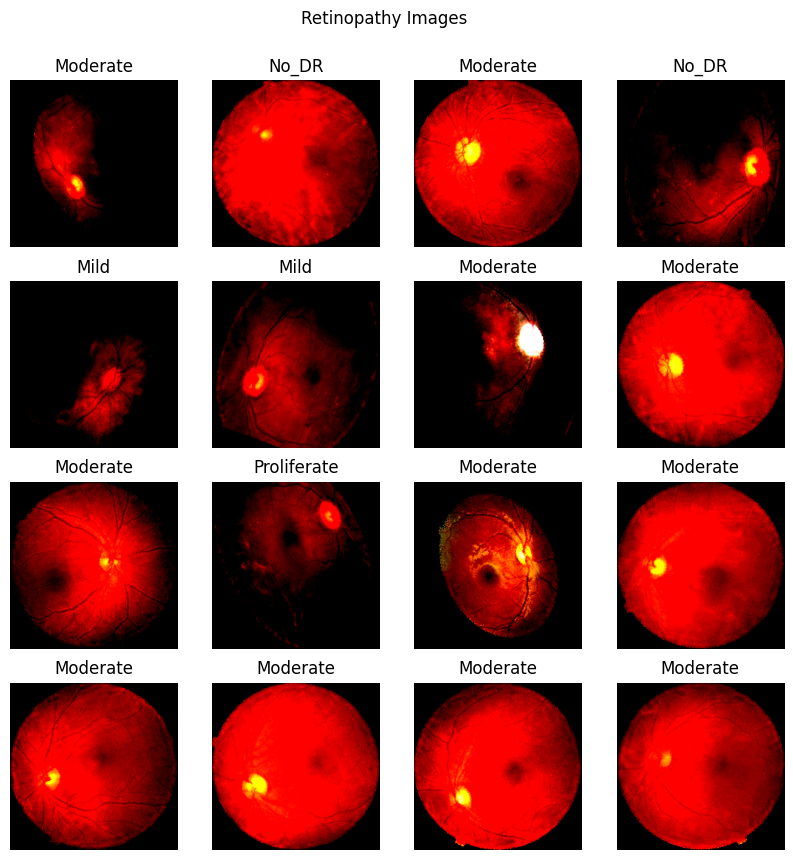

In [5]:
# Visualizing some images from Trainset
# show we show one plot per serverity level? right now feels a bit werid idk

CLA_label = {
        0 : 'No_DR',
        1 : 'Mild',
        2 : 'Moderate',
        3 : 'Proliferate',
        4 : 'Severe',


}

figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Retinopathy Images', y=0.95)

plt.show()

In [6]:
# Import and load Train, Validation and Test set
# TODO : can experiment with the batch size
# train set has 2076 images so can use greater batch size but valid and test have 531 and 231 so must use smaller batch size or there will be overfitting
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 100, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [7]:
# Print shape of Dataset
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([100, 3, 224, 224])
Shape of y: torch.Size([100]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64



In [8]:
# def findConv2dOutShape(hin,win,conv,pool=2):
#     kernel_size = conv.kernel_size
#     stride=conv.stride
#     padding=conv.padding
#     dilation=conv.dilation

#     hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
#     wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

#     if pool:
#         hout/=pool
#         wout/=pool
#     return int(hout),int(wout)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class GoogLeNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(GoogLeNet, self).__init__()
        # Load the pre-trained GoogLeNet model
        self.googlenet = models.googlenet(pretrained=pretrained)
        # Modify the last layer to match the number of classes in your task
        self.googlenet.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        return self.googlenet(x)



In [10]:
params = {
    "shape_in": (3, 224, 224),  # Input shape (channels, height, width)
    "num_classes": 5,  # Number of output classes
}


# Instantiate model
googLeNet_model = GoogLeNet(params["num_classes"], pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
googLeNet_model = googLeNet_model.to(device)

In [12]:
# Model Summary
summary(googLeNet_model, input_size=(3, 224, 224),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

In [13]:
#define loss function
loss_func = nn.CrossEntropyLoss()

In [14]:
opt = optim.Adam(googLeNet_model.parameters(), lr=1e-3)
#can change the parameters here
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [15]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

In [16]:
def train_val(model, params, verbose=False):

    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]

    # history of loss values in each epoch
    loss_history={"train": [],"val": []}
    # histroy of metric values in each epoch
    metric_history={"train": [],"val": []}
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    # initialize best loss to a large value
    best_loss=float('inf')

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.)

    for epoch in tqdm(range(epochs)):

        # Get the Learning Rate
        current_lr = get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))


# Train Model Process


        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)


# Evaluate Model Process


        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)

        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [17]:
params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 80,
 "optimiser": optim.Adam(googLeNet_model.parameters(),lr=1e-3),
 "lr_change": ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1),
 "f_loss": nn.CrossEntropyLoss(),
 "weight_path": "weights.pt",
}

# train and validate the model
model,loss_hist_m,metric_hist_m = train_val(googLeNet_model,params_train)

  0%|          | 0/80 [00:00<?, ?it/s]

<Axes: >

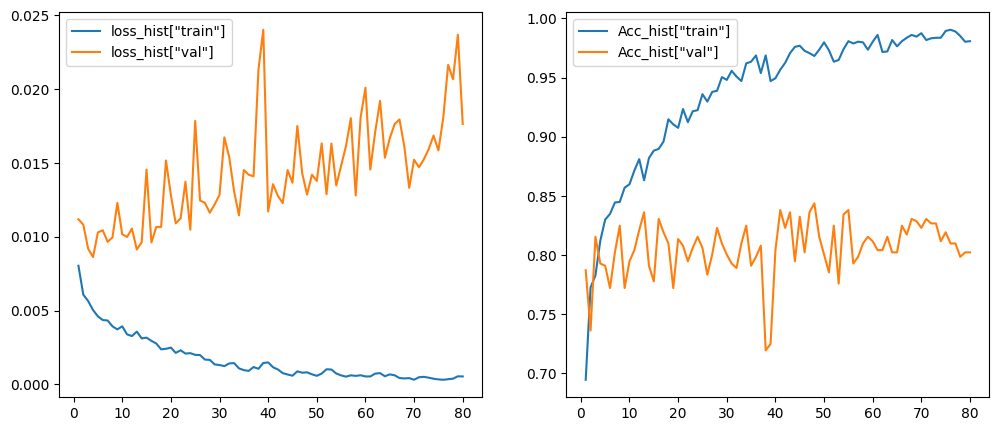

In [18]:
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["val"],ax=ax[1],label='Acc_hist["val"]')

In [19]:
def ture_and_pred_data(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()

        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)

    return y_true, y_pred

In [20]:
# Classification Report for Retinopathy Classification Model based on Train Set
y_true, y_pred = ture_and_pred_data(train_loader, googLeNet_model)
print(classification_report(y_true, y_pred), '\n\n')

              precision    recall  f1-score   support

         0.0       0.50      0.82      0.62       217
         1.0       0.74      0.77      0.75       563
         2.0       0.99      0.98      0.98      1026
         3.0       0.85      0.40      0.54       166
         4.0       0.68      0.22      0.33       104

    accuracy                           0.82      2076
   macro avg       0.75      0.64      0.65      2076
weighted avg       0.84      0.82      0.82      2076
 




In [21]:
 # Classification Report for Retinopathy Classification Model based on Validation Set
y_true, y_pred = ture_and_pred_data(val_loader, googLeNet_model)
print(classification_report(y_true, y_pred), '\n\n')

              precision    recall  f1-score   support

         0.0       0.41      0.72      0.52        57
         1.0       0.70      0.62      0.66       138
         2.0       0.97      0.98      0.98       286
         3.0       0.82      0.29      0.43        31
         4.0       0.50      0.21      0.30        19

    accuracy                           0.79       531
   macro avg       0.68      0.57      0.58       531
weighted avg       0.82      0.79      0.79       531
 




In [22]:
torch.save(googLeNet_model, "googLeNet_model.pt")

In [23]:
# Load the pretrained model
model = torch.load("googLeNet_model.pt")

# Move the model to the GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Iterate over the test loader for prediction
with torch.no_grad():
    for images, _ in test_loader:

        images = images.to(device)
        output = model(images)
        probabilities = torch.softmax(output, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)

        for predicted_class in predicted_classes:
            print("Predicted class:", predicted_class.item())


Predicted class: 2
Predicted class: 2
Predicted class: 0
Predicted class: 1
Predicted class: 2
Predicted class: 2
Predicted class: 1
Predicted class: 1
Predicted class: 2
Predicted class: 0
Predicted class: 4
Predicted class: 2
Predicted class: 1
Predicted class: 2
Predicted class: 1
Predicted class: 2
Predicted class: 2
Predicted class: 1
Predicted class: 2
Predicted class: 2
Predicted class: 0
Predicted class: 2
Predicted class: 2
Predicted class: 2
Predicted class: 1
Predicted class: 1
Predicted class: 2
Predicted class: 2
Predicted class: 2
Predicted class: 0
Predicted class: 1
Predicted class: 2
Predicted class: 1
Predicted class: 1
Predicted class: 2
Predicted class: 4
Predicted class: 1
Predicted class: 2
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 2
Predicted class: 2
Predicted class: 1
Predicted class: 2
Predicted class: 2
Predicted class: 0
Predicted class: 2
Predicted class: 2
Predicted class: 2
Predicted class: 2
Predicted class: 2
Predicted cl

In [24]:
## Classification Report for Retinopathy Classification Model based on Test set
y_true, y_pred = ture_and_pred_data(test_loader, model)
print(classification_report(y_true, y_pred), '\n\n')

              precision    recall  f1-score   support

         0.0       0.40      0.70      0.51        20
         1.0       0.72      0.75      0.74        65
         2.0       0.97      0.98      0.98       118
         3.0       0.75      0.15      0.25        20
         4.0       0.20      0.12      0.15         8

    accuracy                           0.79       231
   macro avg       0.61      0.54      0.53       231
weighted avg       0.81      0.79      0.78       231
 


